### A DISCIPLINED APPROACH TO NEURAL NETWORK HYPER-PARAMETERS: PART 1 – LEARNING RATE, BATCH SIZE, MOMENTUM, AND WEIGHT DECAY

- Reviewing the approach for setting Hyperparameters by Leslie Smith. 
- 'Setting the hyper-parameters remains a black art that requires years of experience to acquire' - Leslie Smith

### Load Dependancies

In [1]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#Import the fastai libraries
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# specify the path of the folder we will be working with
PATH = 'data/pill/small/'

In [5]:
# Specify the csv file that contains the labels for the corresponding images in the training folder
labels_csv = f'{PATH}/classify_test_double.csv'
#labels_csv = f'{PATH}/labels.csv'
n = len(list(open(labels_csv))) -1
val_idxs = get_cv_idxs(n) #Create a validation set = in this case 20% set for validation
#val_idxs = []#use this for not creating a validation set

In [6]:
len(val_idxs) #number in validation set

206

In [7]:
f_model = resnet50 #choose the pretrained model
sz=185
bs=8

In [8]:
#aug_tfms = [RandomLighting(0.25,0.150)] + [RandomDihedral()]
#aug_tfms = [RandomDihedral()] + [RandomRotate(27)]
#aug_tfms = [Cutout(n_holes=200, length=7.5, tfm_y=TfmType.NO)]
aug_tfms = [RandomRotateZoom(deg=45, zoom=2, stretch=1)] + [AddPadding(pad=50, mode=cv2.BORDER_WRAP)] + [RandomDihedral()]
#aug_tfms = RandomRotate(57)
#aug_tfms = RandomFlip()
#aug_tfms = RandomDihedral()
#aug_tfms =[RandomRotate(27)]
#aug_tfms = [AddPadding(pad=50, mode=cv2.BORDER_CONSTANT)] #padding
#aug_tfms = transforms_top_down
#aug_tfms = RandomLighting(0.25,0.15) #No transformations
#aug_tfms = [RandomRotate(10), RandomLighting(0.05, 0.05)] #transforms basic
#aug_tfms = transforms_side_on = transforms_basic + [RandomFlip()] #transforms side on
#aug_tfms = RandomBlur(blur_strengths=99, probability=100) #random blur
#aug_tfms = transforms_top_down = transforms_basic + [RandomDihedral()] # transforms top down
#aug_tfms = RandomRotate(90, p=0.75, mode=cv2.BORDER_REFLECT, tfm_y=TfmType.NO) #Random rotatateaug_tfms = [RandomLighting(b=0.5, c=0.1, tfm_y=TfmType.NO)] # Random Lighting
#aug_tfms = [RandomRotateZoom(deg=45, zoom=2, stretch=1)] #Random Zoom Rotate
#aug_tfms = [RandomRotate(27), RandomLighting(0.15, 0.15), RandomDihedral(), RandomBlur(blur_strengths=71, probability=0.5,
                  #  tfm_y=TfmType.NO), RandomRotateZoom(deg=45, zoom=2, stretch=1)] #aug_full
#aug_tfms =[RandomRotate(10), RandomLighting(0.05, 0.05)] + [RandomFlip()] + [RandomDihedral()] + [RandomZoom(zoom_max=1)] + [RandomStretch(max_stretch=0.5)]

In [9]:
tfms = tfms_from_model(f_model, sz, aug_tfms)
md  = ImageClassifierData.from_csv(PATH, 'train_double', labels_csv, tfms=tfms,
                     val_idxs=val_idxs, test_name='test_600', bs=bs)

In [10]:
x,y=next(iter((md.val_dl)))

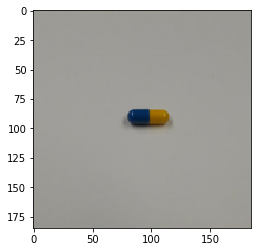

In [11]:
plt.imshow(md.trn_ds.denorm(x)[7]); #look at picture 7 from training set

In [12]:
learn = ConvLearner.pretrained(f_model, md)

### Cyclic Learning Rates

- If the Learning Rate (LR) is too small = Overfitting
- If LR is too large = Divergence
- However large LRs help to regularize the training
- For Cyclic Learning Rates (CLR) you specify specific minimum and maximum learning rate boundaries and a stepsize

In [13]:
learn.lr_find2(end_lr=100)

 97%|█████████▋| 100/103 [00:16<00:00,  6.20it/s, loss=0.641]

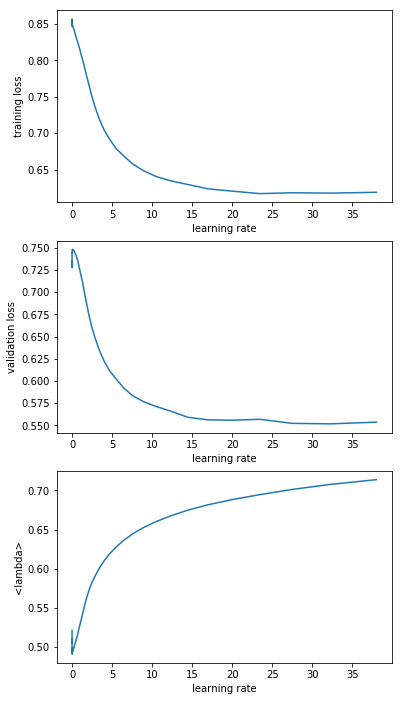

In [14]:
learn.sched.plot(1,5)

## Understanding Fastai code to implement 1-Cycle Policy

- The 1 cycle policy involves a cycle with 2 steps of equal length
- Step 1 where the learning rate increases linearly from the maximum to the minimum
- Step 2 where it linearly decreases

In [21]:
learn.fit(2.0,1,cycle_len=2,use_clr_beta=(10,5,0.95,0.85),wds=1e-5)
#Just an example in order to generate the cycle with 2 steps of equal length

epoch      trn_loss   val_loss   <lambda>                     
    0      0.075126   0.062634   0.98183   
    1      0.072194   0.060749   0.982329                     


[array([0.06075]), 0.9823285595884601]

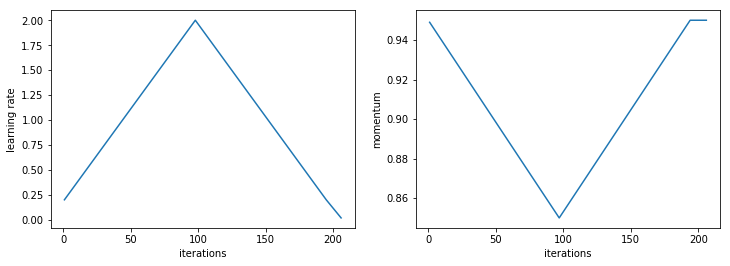

In [22]:
learn.sched.plot_lr()

- The peak in the middle of the cycle (at 100 iterations) acts as a regularization method to prevent overfitting

## Batch Size and LR

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [ ]:
#Use low BS and low LR
bs=8
lr=0.01

In [ ]:
%time
learn.fit(lr,2,cycle_len=2,use_clr_beta=(10,0.25,0.95,0.85),wds=1e-5)
#better results with using lower 5% of the cycle dedicated to the end of the cycle

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(list(range(4)),learn.sched.rec_metrics)
ax.set_title('Low BS and Low LR')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [ ]:
#High BS and Low LR
bs=128
lr=0.01

In [ ]:
%time
learn.fit(lr,2,cycle_len=2,use_clr_beta=(10,0.25,0.95,0.85),wds=1e-5)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(list(range(4)),learn.sched.rec_metrics)
ax.set_title('High BS and Low LR')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [ ]:
#Low BS and High LR
bs=8
lr=2.0

In [ ]:
%time
learn.fit(lr,2,cycle_len=2,use_clr_beta=(10,0.25,0.95,0.85),wds=1e-5)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(list(range(4)),learn.sched.rec_metrics)
ax.set_title('Low BS and High LR')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [ ]:
#High BS and High LR
bs=128
lr=2.0

In [ ]:
%time
learn.fit(lr,2,cycle_len=2,use_clr_beta=(10,0.25,0.95,0.85),wds=1e-5)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(list(range(4)),learn.sched.rec_metrics)
ax.set_title('High BS and High LR')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

## BS and LR analysis

![title](img/BS_LR.png)

- Low BS and High LR as well as High BS and High LR produce the highest accuracy

## Learning & Validation Losses Weight Decay 

- Use this to test the Weight Decay

In [ ]:
%time
learn.fit(3.0,1,cycle_len=30,use_clr_beta=(10,5,0.95,0.85),wds=1e-1)
#better results with using lower 5% of the cycle dedicated to the end of the cycle

In [ ]:
learn.sched.plot_lr()

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(30)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(30)),[learn.sched.losses[i] for i in range(32,30*34,33)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(30)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

## Learning & Validation Losses based on Weight Decay Analysis

![title](img/Under_over.png)

- Pictorial explanation of the tradeoff between underfitting and overfitting


### 1e5, 1e4, 1e3, 1e2

![title](img/loss.png)

- The graphs from left to right potray Training (Orange) and Validation (Blue) Loss plots with a Weight Decay(wds) of 1e5, 1e4, 1e3 and 1e2
- The graphs show that the Training loss is above the Validation loss when the wds is 1e5 and 1e4 but the two losses then intersect when the wds is 1e3 and 1e2